<a href="https://colab.research.google.com/github/gregor-posadas/Gregor-Projects/blob/main/WWTP_Heatmap_Correlation_Program_12A_(Process_Based_Correlation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Upload data files for the WWTP unit processes in sequence.
Enter the full path to the next process file (e.g., Influent): /content/Influent Parameters.csv
What is the name of this process? (e.g., Influent): Influent
Do you want to add another process file? (yes/no): yes
Enter the full path to the next process file (e.g., Influent): /content/Oxidation Ditch Effluent Parameters.xlsx
What is the name of this process? (e.g., Influent): Oxidation Ditch Effluent
Do you want to add another process file? (yes/no): yes
Enter the full path to the next process file (e.g., Influent): /content/Plant Effluent Parameters.xlsx
What is the name of this process? (e.g., Influent): Plant Effluent
Do you want to add another process file? (yes/no): no
Reading file: /content/Influent Parameters.csv
Applying Z-Score Method to filter outliers...
Finished processing file: /content/Influent Parameters.csv
Reading file: /content/Oxidation Ditch Effluent Parameters.xlsx
Applying Z-Score Method to filter outliers..

Generating heatmap between Oxidation Ditch Effluent and Plant Effluent...
Aligning datasets for Oxidation Ditch Effluent and Plant Effluent...
Reading file: /content/Oxidation Ditch Effluent Parameters.xlsx
Applying Z-Score Method to filter outliers...
Finished processing file: /content/Oxidation Ditch Effluent Parameters.xlsx
Reading file: /content/Plant Effluent Parameters.xlsx
Applying Z-Score Method to filter outliers...
Finished processing file: /content/Plant Effluent Parameters.xlsx
Datasets aligned for Oxidation Ditch Effluent and Plant Effluent.
Bootstrapping correlation matrices...
Bootstrapping iteration 0/500...
Bootstrapping iteration 100/500...
Bootstrapping iteration 200/500...
Bootstrapping iteration 300/500...
Bootstrapping iteration 400/500...
Bootstrapping iteration 0/500...
Bootstrapping iteration 100/500...
Bootstrapping iteration 200/500...
Bootstrapping iteration 300/500...
Bootstrapping iteration 400/500...
Bootstrapping iteration 0/500...
Bootstrapping iteratio

Generating network diagram for the processes...


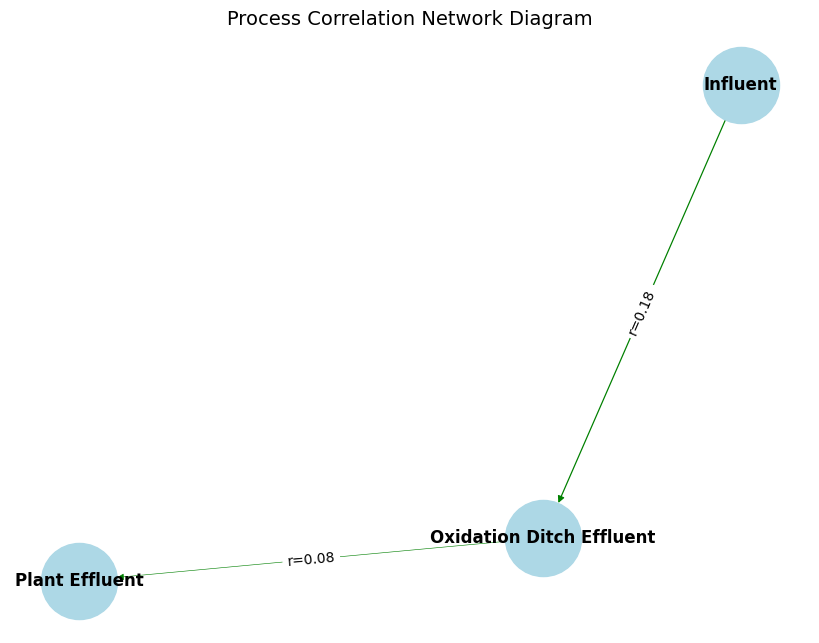

In [4]:
import pandas as pd
import numpy as np
import plotly.express as px
from scipy import stats
from statsmodels.stats.multitest import multipletests
from sklearn.utils import resample
import itertools
import matplotlib.pyplot as plt
import networkx as nx


# Function to remove outliers using Z-score
def remove_outliers_zscore(df, threshold=3):
    """
    Remove outliers from a DataFrame using the Z-score method.
    """
    print("Applying Z-Score Method to filter outliers...")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    z_scores = np.abs(stats.zscore(df[numeric_cols], nan_policy="omit"))
    mask = (z_scores < threshold).all(axis=1)
    return df[mask]


# Sequential file upload
def upload_files_sequentially():
    process_files = []
    process_labels = []

    while True:
        process_file = input("Enter the full path to the next process file (e.g., Influent): ")
        process_label = input(f"What is the name of this process? (e.g., Influent): ")

        process_files.append(process_file)
        process_labels.append(process_label)

        add_another = input("Do you want to add another process file? (yes/no): ").strip().lower()
        if add_another != 'yes':
            break

    return process_files, process_labels


# Read and align datasets with Z-score filtering
def read_file(file_path):
    """
    Read an Excel or CSV file into a DataFrame and normalize column names, with Z-score filtering.
    """
    try:
        print(f"Reading file: {file_path}")
        if file_path.endswith(".xlsx") or file_path.endswith(".xls"):
            df = pd.read_excel(file_path)
        elif file_path.endswith(".csv"):
            df = pd.read_csv(file_path)
        else:
            raise ValueError("Unsupported file format. Please use .xlsx, .xls, or .csv files.")

        df.columns = df.columns.str.lower().str.strip()
        if 'date' not in df.columns:
            raise KeyError(f"The file {file_path} does not contain a 'date' column.")
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df = df.dropna(subset=["date"])  # Drop rows with invalid dates
        df = remove_outliers_zscore(df)  # Apply Z-score filtering
        print(f"Finished processing file: {file_path}")
        return df
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        raise


def align_datasets(file1, file2, label1, label2):
    """
    Align two datasets based on the 'date' column, with Z-score filtering.
    """
    print(f"Aligning datasets for {label1} and {label2}...")
    df1 = read_file(file1)
    df2 = read_file(file2)

    merged_df = pd.merge(df1, df2, on="date", suffixes=(f"_{label1}", f"_{label2}"))
    merged_df = merged_df.set_index("date")
    print(f"Datasets aligned for {label1} and {label2}.")
    return merged_df


# Statistical analysis
def bootstrap_correlations(df, n_iterations=500, method='pearson'):
    correlations = []
    for i in range(n_iterations):
        if i % 100 == 0:
            print(f"Bootstrapping iteration {i}/{n_iterations}...")
        df_resampled = resample(df)
        corr_matrix = df_resampled.corr(method=method)
        correlations.append(corr_matrix)

    median_corr = pd.concat(correlations).groupby(level=0).median()
    return median_corr


def calculate_p_values(df, method='pearson'):
    print("Calculating p-values for correlation matrix...")
    p_values = pd.DataFrame(np.ones((df.shape[1], df.shape[1])), columns=df.columns, index=df.columns)
    for col1, col2 in itertools.combinations(df.columns, 2):
        _, p_val = stats.pearsonr(df[col1], df[col2])
        p_values.at[col1, col2] = p_val
        p_values.at[col2, col1] = p_val
    return p_values


def correct_p_values(p_values):
    print("Correcting p-values using Benjamini-Hochberg method...")
    _, corrected, _, _ = multipletests(p_values.values.flatten(), alpha=0.05, method='fdr_bh')
    corrected_p = pd.DataFrame(corrected.reshape(p_values.shape), index=p_values.index, columns=p_values.columns)
    return corrected_p


# Find common parameters across DataFrames
def find_common_parameters(dataframes):
    """
    Identify common parameters across all dataframes.
    """
    common_columns = set(dataframes[0].columns)
    for df in dataframes[1:]:
        common_columns.intersection_update(df.columns)
    return list(common_columns - {'date'})  # Exclude the 'date' column


# Generate Heatmap
def generate_interactive_heatmap(df, title, labels):
    """
    Generate an interactive heatmap with consistent axis alignment and diagonal of 1.00.
    """
    df = df.dropna().apply(pd.to_numeric, errors='coerce')

    print("Bootstrapping correlation matrices...")
    pearson_corr = bootstrap_correlations(df, n_iterations=500, method='pearson')
    spearman_corr = bootstrap_correlations(df, n_iterations=500, method='spearman')
    kendall_corr = bootstrap_correlations(df, n_iterations=500, method='kendall')

    avg_corr_matrix = (pearson_corr + spearman_corr + kendall_corr) / 3

    print("Calculating and correcting p-values...")
    pearson_p_values = calculate_p_values(df, method='pearson')
    corrected_p_values = correct_p_values(pearson_p_values)

    sig_mask = (corrected_p_values < 0.05).astype(int)

    filtered_corr_matrix = avg_corr_matrix.where(sig_mask > 0).fillna(0)

    parameter_order = sorted(filtered_corr_matrix.index)
    filtered_corr_matrix = filtered_corr_matrix.loc[parameter_order, parameter_order]

    np.fill_diagonal(filtered_corr_matrix.values, 1)

    print("Generating heatmap...")
    fig = px.imshow(
        filtered_corr_matrix,
        text_auto=".2f",
        color_continuous_scale="RdBu",
        zmin=-1,
        zmax=1,
        labels={"x": labels[0], "y": labels[1], "color": "Correlation Coefficient"},
        title=title,
    )

    fig.update_layout(
        title=dict(font=dict(size=20), x=0.5),
        xaxis=dict(tickangle=45, title=None, tickfont=dict(size=12)),
        yaxis=dict(title=None, tickfont=dict(size=12)),
        autosize=False,
        width=1200,
        height=1000,
        margin=dict(l=100, r=100, t=100, b=100),
    )

    fig.show()
    return filtered_corr_matrix


# Generate Network Diagram
def generate_network_diagram(labels, correlations):
    G = nx.DiGraph()

    for i in range(len(labels) - 1):
        G.add_edge(labels[i], labels[i + 1], weight=abs(correlations[i]), correlation=correlations[i])

    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(8, 6))
    edge_colors = ['green' if G[u][v]['correlation'] > 0 else 'red' for u, v in G.edges()]
    edge_widths = [G[u][v]['weight'] * 5 for u, v in G.edges()]
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_size=3000,
        node_color="lightblue",
        font_size=12,
        font_weight="bold",
        edge_color=edge_colors,
        width=edge_widths,
    )
    edge_labels = {(u, v): f"r={G[u][v]['correlation']:.2f}" for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
    plt.title("Process Correlation Network Diagram", fontsize=14)
    plt.show()


# Main Function
if __name__ == "__main__":
    print("Upload data files for the WWTP unit processes in sequence.")
    process_files, process_labels = upload_files_sequentially()

    # Validate file count
    if len(process_files) < 3:
        print("Error: You need at least three files to generate diagrams.")
        exit()

    # Read and process data files
    dataframes = [read_file(file) for file in process_files]

    # Find common parameters
    common_params = find_common_parameters(dataframes)
    if not common_params:
        print("Error: No common parameters found across the processes.")
        exit()

    # Compute correlations between processes
    correlations = []
    for i in range(len(dataframes) - 1):
        df1 = dataframes[i][['date'] + common_params]
        df2 = dataframes[i + 1][['date'] + common_params]
        merged_df = pd.merge(df1, df2, on="date")
        corr_matrix = merged_df.drop(columns=['date']).corr()
        avg_corr = corr_matrix.mean().mean()
        correlations.append(avg_corr)

    # Identify parameters that passed the conditions for the network diagram
    valid_parameters = []
    for param in common_params:
        valid_count = sum(param in df.columns for df in dataframes)
        if valid_count >= 3:  # Ensure the parameter exists in at least 3 processes
            param_correlations = []
            for i in range(len(dataframes) - 1):
                df1 = dataframes[i][['date', param]]
                df2 = dataframes[i + 1][['date', param]]
                merged_df = pd.merge(df1, df2, on="date")
                corr_matrix = merged_df.drop(columns=['date']).corr()
                if not corr_matrix.empty and corr_matrix.iloc[0, 1] != 0:  # Check for non-zero correlation
                    param_correlations.append(corr_matrix.iloc[0, 1])
            if param_correlations:  # Include only if at least one non-zero correlation exists
                valid_parameters.append(param)

    # Print the validated parameters
    if valid_parameters:
        print("\nThe following parameters passed the conditions for network diagram production:")
        for param in valid_parameters:
            print(f"- {param}")
    else:
        print("\nNo parameters passed the conditions for network diagram production.")
        exit()

    # Generate heatmaps for each pair of processes
    for i in range(len(process_files) - 1):
        print(f"Generating heatmap between {process_labels[i]} and {process_labels[i + 1]}...")
        merged_df = align_datasets(process_files[i], process_files[i + 1], process_labels[i], process_labels[i + 1])
        title = f"Interactive Heatmap: {process_labels[i]} vs {process_labels[i + 1]}"
        labels = (process_labels[i], process_labels[i + 1])
        generate_interactive_heatmap(merged_df, title, labels)

    # Generate network diagram
    print("Generating network diagram for the processes...")
    generate_network_diagram(process_labels, correlations)
